# Train an Object Detection Model for Highlights Localization in Documents
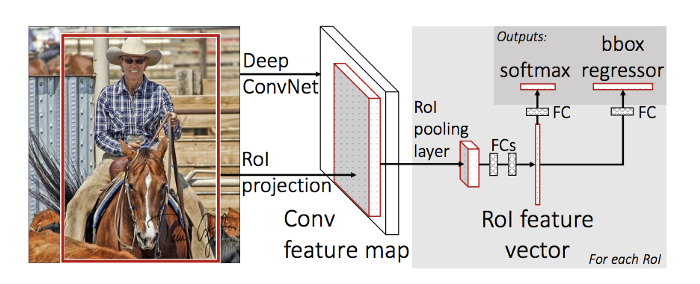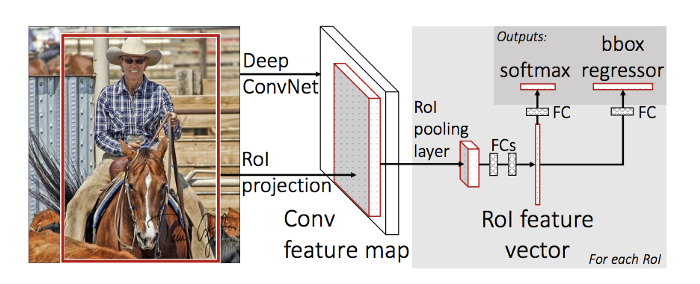

## Import packages

In [ ]:
import os
import sys
import numpy as np

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
import numpy as np
import torch
import torch.utils.data
import pandas as pd
import albumentations as A

sys.path.append('./faster_RCNN/')
from engine import train_one_epoch, evaluate
import utils
from obj_detection_dataset_class import ObjectDetectionDataset


## Data loading and preprocessing

In [ ]:
# define data augmentation transformations

train_transforms = A.Compose([
    A.Rotate(limit=25, p=.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=.1),
    A.Perspective(p=.2),
    A.ColorJitter(p=.5),
    A.Resize(256, 256)
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=[]))

test_transforms = A.Compose([
    A.Resize(256, 256)
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=[]))

In [ ]:
train_df = pd.read_pickle('train_df.pkl')
valid_df = pd.read_pickle('valid_df.pkl')

In [ ]:
train_df.head(3)

In [ ]:
# use our dataset and defined transformations
train_dataset = ObjectDetectionDataset(data_df=train_df,
                         transforms=train_transforms)
valid_dataset = ObjectDetectionDataset(data_df=valid_df,
                         transforms=test_transforms)

In [ ]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=8,
                                                shuffle=False,
                                                num_workers=4,
                                                collate_fn=utils.collate_fn)

## Model definition

In [ ]:
# define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# create checkpoint folder
checkpoints_dir = 'trained_models'
os.makedirs(checkpoints_dir, exist_ok=True)
print('Working on:', device)

In [ ]:
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# our dataset has two classes only - background and H
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)

# load the model to the right device
model.to(device)
print('Model loaded on:', device)

In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# model summary
print(model)

## Training

In [ ]:
# number of epochs
num_epochs = 20
#start training
for epoch in range(num_epochs):
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)
    
    # save model afeter the current epoch
    checkpoint_path = os.path.join(checkpoints_dir, 'checkpoint-' + str(epoch).zfill(2)+ '.pt')
    torch.save(model, checkpoint_path)
    print('\n\n')